 # First PyTorch Program
 
 The following rudimentary model code is implemented from the PyTorch beginner's tutorial page: [PyTorch Quickstart Tutorial](https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html). The model is built to make predictions on the FashionMNIST dataset.
 

In [29]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

## Loading Data

In [2]:
#### Train data
train_data = datasets.FashionMNIST(
    root = 'Data',
    train = True,
    download = True,
    transform = ToTensor()
)

#### Test data
test_data = datasets.FashionMNIST(
    root = 'Data',
    train = False,
    download = True,
    transform = ToTensor()
)

In [34]:
print('Length of train dataset : ', len(train_data))
print('Length of test dataset : ', len(test_data))

Length of train dataset :  60000
Length of test dataset :  10000


## Wrapping dataset with a DataLoader()

Data Loader allows the dataset to be interable. The DataLoader allows batching, sampling, shuffling and multi-process data loading. 

In [4]:
batch_size = 64

train_dataloader = DataLoader(train_data, batch_size = batch_size)
test_dataloader = DataLoader(test_data, batch_size = batch_size)

for X, y in test_dataloader:
    print('Shape of X [N, C, H, W] = ', X.shape)
    print('Shape of y = ', y.shape)
    print('Dtype of y = ', y.dtype)
    break

Shape of X [N, C, H, W] =  torch.Size([64, 1, 28, 28])
Shape of y =  torch.Size([64])
Dtype of y =  torch.int64


The size of one batch of the test DataLoader is printed above. In the dimensions of **X**:

- **N** represents the number of data points in the batch, which is specified as 64.
- **C** is the number of channels. For the FashionMNIST dataset, images have only one color channel.
- **H** and **W** are the height and width of the images, respectively, both of which are 28.

The target variable **y** is an integer indicating which class the image belongs to. There are a total of 10 classes.

## Creating Models

To define the architecture of the model we are building, we create a class that specifies all the layers of the neural network and how data passes through them. This class inherits from `nn.Module`. The architecture is defined in the `__init__` function, and the data passing logic is implemented in the `forward` function.

In [5]:
class NeuralNetwork(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.network = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512), 
            nn.ReLU(),
            nn.Linear(512, 10)
        )
    
    
    def forward(self, x):
        x = self.flatten(x)
        out = self.network(x)
        return out

In [6]:
model = NeuralNetwork()
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (network): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


## Training the model and Optimizing the model parameters

For training the model and optimizing the parameters, we need to define a loss function and the optimization method. For the current code, we are using the cross entropy loss, and Stochastic Gradient descent optimization.

In [14]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 1e-3) # The learning rate is set as 1e-3

The cross-entropy loss $ L $ is defined as:

$$ L = -\sum_{i=1}^{N} \sum_{c=1}^{C} y_{i,c} \log(\hat{y}_{i,c}) $$

where:
- $ N $ is the number of samples 
- $ C $ is the number of classes
- $ y_{i,c} $ is the binary indicator (0 or 1) if class label $ c $ is the correct classification for sample $ i $
- $ \hat{y}_{i,c} $ is the predicted probability that sample $ i $ belongs to class $ c $


The update rule for stochastic gradient descent is:

$$ \theta = \theta - \eta \nabla_{\theta} J(\theta; x^{(i)}; y^{(i)}) $$

where:
- $ \theta $ is the parameter vector.
- $\eta $ is the learning rate.
- $ \nabla_{\theta} J(\theta; x^{(i)}; y^{(i)}) $ is the gradient of the cost function $ J $ with respect to the parameters $ \theta $ for the i-th training example $ (x^{(i)}, y^{(i)}) $.


### Training Function

The training function computes the error in prediction and uses back propagation to adjust the model parameters. 

In [21]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)     # Size of the training set
    model.train()
    
    for batch, (X,y) in enumerate(dataloader):
        pred = model(X)
        loss = loss_fn(pred, y)
        
        #### Back Propagation
        loss.backward()                 # Compute the derivatives
        optimizer.step()                # Updating the model parameters
        optimizer.zero_grad()           # Setting the grad values to zero after one step of updating parameters
        
        #### Print the training progress
        if batch%100 == 0:
            current = (batch+1)*len(X)    # No. of data points the model has been trained on
            loss = loss.item()          # Get the loss value of the current training sample
            print(f"Loss : {loss:>7f} [{current:>5d} / {size:>5d}]")
            

### Test Function

The test function is to check the performance of the adjusted model parameters on the test set. The errors from the test set are not used in the parameter optimization to avoid over fitting and generalize the model to unseen data points. The train and test loss are monitored to ensure that the model is learning.

In [16]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    batches = len(dataloader)
    
    model.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for (X,y) in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(axis = 1) == y).type(torch.float).sum().item()
            
        test_loss = test_loss/batches
        correct = correct/ size
        
    print(f"Test Error: Average Loss = {test_loss:>8f}, Accuracy = {correct*100 :>0.1f}%")

In [22]:
#### Implement model training

epochs = 5

for t in range(epochs):
    print(f"\nEpoch {t+1} \n______________________________")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)

print('Training completed!')

Epoch 1 
______________________________
Loss : 1.671026 [   64 / 60000]
Loss : 1.637307 [ 6464 / 60000]
Loss : 1.481301 [12864 / 60000]
Loss : 1.558274 [19264 / 60000]
Loss : 1.439580 [25664 / 60000]
Loss : 1.419454 [32064 / 60000]
Loss : 1.440982 [38464 / 60000]
Loss : 1.350231 [44864 / 60000]
Loss : 1.390479 [51264 / 60000]
Loss : 1.279226 [57664 / 60000]
Test Error: Average Loss = 1.310160, Accuracy = 63.6%
Epoch 2 
______________________________
Loss : 1.386322 [   64 / 60000]
Loss : 1.363456 [ 6464 / 60000]
Loss : 1.192834 [12864 / 60000]
Loss : 1.302594 [19264 / 60000]
Loss : 1.177310 [25664 / 60000]
Loss : 1.193406 [32064 / 60000]
Loss : 1.213665 [38464 / 60000]
Loss : 1.144922 [44864 / 60000]
Loss : 1.188989 [51264 / 60000]
Loss : 1.089250 [57664 / 60000]
Test Error: Average Loss = 1.120105, Accuracy = 65.0%
Epoch 3 
______________________________
Loss : 1.190905 [   64 / 60000]
Loss : 1.189152 [ 6464 / 60000]
Loss : 1.004328 [12864 / 60000]
Loss : 1.145257 [19264 / 60000]
Loss

## Making Predictions with the model

Now that the model is trained and ready to be used, we can try some sample predictions

In [24]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

Predicted: Coat, Actual: Coat


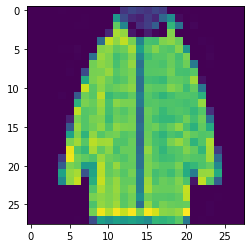

In [33]:
model.eval()

i = 888     #Give values from 0 to 9999 to test the model predictions
x,y = test_data[i][0], test_data[i][1]

with torch.no_grad():
    pred = model(x)
    predicted, actual = classes[pred[0].argmax()], classes[y]
    
plt.imshow(x.permute(1, 2, 0))
print(f"Predicted: {predicted}, Actual: {actual}")